In [1]:
import numpy as np
from scipy.integrate import solve_ivp 
from matplotlib import pyplot as plt
%matplotlib inline 

In [2]:
def normalize(obj):

    return obj / np.linalg.norm(obj)

def skew_symm(vec):

    if vec.ndim != 1:
        raise Exception("Not a vector")
    if len(vec) != 3:
        raise Exception("Wrong number of coordinates in vector: {}, should be 3".format(len(vec)))

    return np.array([[0., -vec[2], vec[1]],[vec[2], 0., -vec[0]],[-vec[1], vec[0], 0.]])

def cross_product(a, b):

    def check_dimensions(vec, string):

        if vec.ndim != 1:
            raise Exception("The {} input is not a vector".format(string))
        if len(vec) != 3:
            raise Exception("Wrong number of coordinates in the {0} vector: {1}, should be 3".format(string, len(vec)))

    check_dimensions(a, 'first')
    check_dimensions(b, 'second')

    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

def quat_product(q1, q2):

    def check_dimensions(q, string):

        if q.ndim != 1:
            raise Exception("The {} input is not a quaternion".format(string))
        if len(q) != 4:
            raise Exception("Wrong number of coordinates in the {0} quaternion: {1}, should be 4".format(string, len(q)))

    check_dimensions(q1, 'first')
    check_dimensions(q2, 'second')

    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:].dot(q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross_product(q1[1:], q2[1:])

    return q

def rotate_vec_with_quat(q, vec):

    def check_dimensions(obj, is_quat):

        if obj.ndim != 1:
            raise Exception("Not a {}".format('quaternion' * is_quat + 'vector' * (1 - is_quat)))
        if len(obj) != (3 + 1 * is_quat):
            raise Exception("Wrong number of coordinates in the {0}: {1}, should be {2}"
                            .format('quaternion' * is_quat + 'vector' * (1 - is_quat), len(obj), 3 + 1 * is_quat))

    check_dimensions(q, True)
    check_dimensions(vec, False)

    q = quat_conjugate(q)

    qxvec = cross_product(q[1:], vec)

    return q[1:].dot(vec) * q[1:] + q[0]**2. * vec + 2. * q[0] * qxvec + cross_product(q[1:], qxvec)

def quat2rpy(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]

def quat_conjugate(q):

    q_new = np.copy(q)
    q_new[1:] *= -1.

    return q_new

In [3]:
MU = 3.986e+14                                 # [m^3 / s^2] standard gravitational parameter of the Earth
MU_0 = 1.257e-6                                # [N / A^2] vacuum permeability
MU_e = 7.94e+22                                # [A * m^2] magnetic dipole moment of the Earth

R_e = 6371e+3                                  # [m] radius of the Earth
altitude = 409e+3                              # [m] altitude of the orbit
incl = 51.63*np.pi / 180                              # [rad] inclination of the orbit

R_orb = R_e + altitude                         # [m] radius of the orbit
omega_0 = np.sqrt(MU / R_orb**3.)              # [rad / s] angular velocity on the orbit
B_0 = MU_e * MU_0 / (4 * np.pi * R_orb**3.)    # [T] magnitude of the magnetic field  on the orbit
B_1 = MU_0 / (4 * np.pi)
         
J = np.diag(np.array([0.014, 0.015, 0.007]))     # [kg * m^2] inertia tensor for satellite
Kw = 60 / omega_0                               # [N * m * s / T^2] stabilizing parameter for PID-regulator
Ka = 12                                          # [N * m / T^2] orientating parameter for PID-regulator

m_max = 0.1                                     # [A * m^2] maximal dipole moment
B_bias = 0*1e-9                                     # [T] magnetometer bias
sigma_meas = 0*1e-8                                  # [T] magnetometer measurement deviation
sigma_M = 0*5*1e-9                                    # [N * m] disturbance of the torque
sigma_gyro = 0*1e-7                               # [T] gyroscope measurement deviation
sigma_B_actual = 0*1e-8                             # [T] noise to create actual magnetic field


X_0 = np.zeros(7)                              # initial state vector
X_0[0:4] = np.array([0.157, 0.693, 0.593, 0.378])   # just for tests I chose not random vector
X_0[0:4] /= np.linalg.norm(X_0[0:4])
X_0[4] = 1e-2
X_0[5] = 1e-2                                      # [rad / s]
X_0[6] = 1e-2                                          # [rad / s]


T_meas = 1                                       # [s] sampling time step
T_ctrl = 5                                      # [s] control time step
T_loop = T_meas + T_ctrl

In [4]:
# external torques

def grav_torque(quat, orb_ang_vel, J):

    Ae3 = rotate_vec_with_quat(quat, np.array([0., 0., 1.]))

    return 3. * orb_ang_vel**2. * cross_product(Ae3, J.dot(Ae3))

def dstrb_torque(sigma):

    return np.random.normal(0, sigma)

def external_torque(quat, orb_ang_vel, inertia_tensor, sigma):

    return grav_torque(quat, orb_ang_vel, inertia_tensor) \
         + dstrb_torque(sigma)

In [5]:
# control torques

def magnetic_moment(quat, Omega_rel, magnetic_field, Kw, Ka, m_max):

    if quat[0] == 0.:

        multiplier = 1.

    else:

        multiplier = np.sign(quat[0])

    S = 4. * quat[1:] * multiplier

    m = -Kw * cross_product(magnetic_field, Omega_rel) - Ka * cross_product(magnetic_field, S)

    if max(abs(m)) > m_max:
        m *= m_max / max(abs(m))
    
    return m

def ctrl_torque(m, actual_magnetic_field):

    return cross_product(m, actual_magnetic_field)

In [6]:
def magnetometer_readings(quat, B_env, B_bias, sigma_B):

    return B_env + B_bias + np.random.normal(0, sigma_B, 3)

# def measurement_model(quat, B_orb, sigma_B):

#     return rotate_vec_with_quat(quat, B_orb) + np.random.normal(0, sigma_B, 3)

In [7]:
def B_fun(u, i=incl, B_0=B_0):

    """
    Magnetic field on the orbit
    :param u: latitude in rad
    :param i: inclination in rad
    :returns: 3-axis magnetic field
    """

    return np.array([np.cos(u)*np.sin(i), np.cos(i), -2.*np.sin(u)*np.sin(i)]) * B_0 

In [8]:
def solve_euler_equation(t, T, x_init, J, J_inv, omega_0, m_ctrl, sigma_M, sigma_B_actual):
    
    def fun(u, x):

        q = x[:4]
        omega = x[4:]
        
        omega_rel = omega - rotate_vec_with_quat(q, np.array([0., omega_0, 0.]))
        
        B_orb = B_fun(omega_0 * (t+u))
        B_env = rotate_vec_with_quat(q, B_orb) + np.random.normal(0, sigma_B_actual, 3)
        
        M = external_torque(q, omega_0, J, sigma_M) + ctrl_torque(m_ctrl, B_env)

        x_dot = np.zeros(7)

        x_dot[4:] = J_inv.dot(M - cross_product(omega, J.dot(omega)))
        x_dot[0] = -0.5 * q[1:].dot(omega_rel)
        x_dot[1:4] = 0.5 * (q[0] * omega_rel + cross_product(q[1:],omega_rel))

        
        return x_dot

    

    x_new = solve_ivp(fun, (0, T), x_init).y[:,-1]
    return x_new

In [9]:
def dynamics(N, T_loop, T_meas, T_ctrl, X_0, J, omega_0, 
                        Kw, Ka, sigma_M, sigma_meas, m_max, B_bias, 
                        sigma_B_actual, sigma_gyro, incl=incl):

    J_inv = np.linalg.inv(J)

    X = np.zeros((7, N))    # state vector
    X[:,0] = X_0
    X[:4,0] = normalize(X[:4,0])

    Omega_rel = np.zeros((3, N))

    t = 0
    
    m = np.zeros((3,N))
    m[:,0] = np.array([0,0,0])

    B_sens = np.zeros((3,N))
    B_sens[:,0] = np.zeros(3)

    for i in range(1, N): 
         
        B_orb = B_fun(omega_0 * (t))
        B_env = rotate_vec_with_quat(X[:4,i-1], B_orb) + np.random.normal(0, sigma_B_actual, 3)
        B_sens[:,i] = magnetometer_readings(X[:4,i], B_env, B_bias, sigma_meas)
# control

        X[:7,i] = solve_euler_equation(t, T_ctrl, X[:7,i-1], J, J_inv, omega_0, 
                                      m[:,i-1], sigma_M, sigma_B_actual)               
        X[:4,i] = normalize(X[:4,i])         #normalization
        
        t += T_ctrl    
        
# measurment
        
        t += T_meas

        X[:7,i] = solve_euler_equation(t, T_meas, X[:7,i], J, J_inv, omega_0, 
                                       np.array([0,0,0]), sigma_M, sigma_B_actual)
        X[:4,i] = normalize(X[:4,i])         #normalization
        
# control moment

        Omega_rel[:,i] = X[4:7,i] - rotate_vec_with_quat(X[:4,i], np.array([0., omega_0, 0.]))
        m[:,i] =  magnetic_moment(X[:4,i], Omega_rel[:,i], B_sens[:,i], Kw, Ka, m_max)

        

    return X, Omega_rel

In [10]:
%%time
N = 3000

time_sec = np.linspace(0, (N-1)*(T_meas + T_ctrl), N)
time_hours = time_sec / 3600.

X, Omg = dynamics(N, T_loop, T_meas, T_ctrl, X_0, J, omega_0, 
                        Kw, Ka, sigma_M, sigma_meas, m_max, B_bias, 
                        sigma_B_actual, sigma_gyro)


Wall time: 1min 29s


In [11]:
roll, pitch, yaw = quat2rpy(X[0], X[1], X[2], X[3])

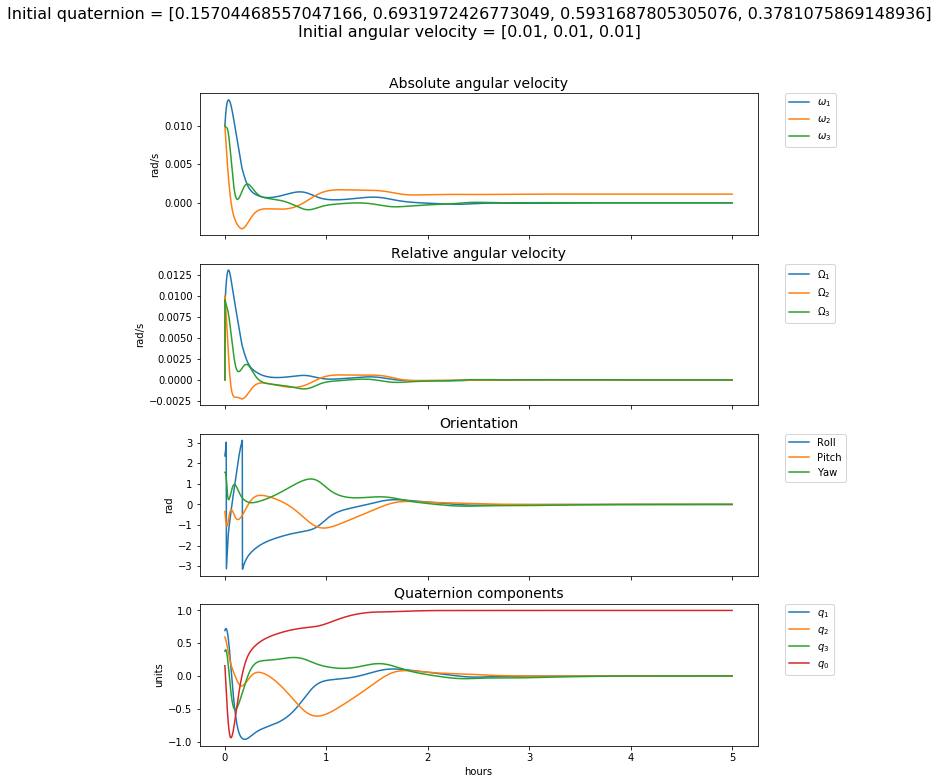

In [12]:
f, ax = plt.subplots(4, sharex=True, figsize=(10,12))
f.suptitle('Initial quaternion = [{0}, {1}, {2}, {3}]\nInitial angular velocity = [{4}, {5}, {6}]'
           .format(X_0[0], X_0[1], X_0[2], X_0[3], round(X_0[4], 3), round(X_0[5], 3), round(X_0[6], 3)), fontsize=16)
ax[0].plot(time_hours, X[4], label='$\omega_1$')
ax[0].plot(time_hours, X[5], label='$\omega_2$')
ax[0].plot(time_hours, X[6], label='$\omega_3$')
ax[0].set_title('Absolute angular velocity', fontsize=14)
ax[0].set_ylabel('rad/s', fontsize=10)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
ax[1].plot(time_hours, Omg[0], label='$\Omega_1$')
ax[1].plot(time_hours, Omg[1], label='$\Omega_2$')
ax[1].plot(time_hours, Omg[2], label='$\Omega_3$')
ax[1].set_title('Relative angular velocity', fontsize=14)
ax[1].set_ylabel('rad/s', fontsize=10)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
ax[2].plot(time_hours, roll, label='Roll')
ax[2].plot(time_hours, pitch, label='Pitch')
ax[2].plot(time_hours, yaw, label='Yaw')
ax[2].set_title('Orientation', fontsize=14)
ax[2].set_ylabel('rad', fontsize=10)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
ax[3].plot(time_hours, X[1], label='$q_1$')
ax[3].plot(time_hours, X[2], label='$q_2$')
ax[3].plot(time_hours, X[3], label='$q_3$')
ax[3].plot(time_hours, X[0], label='$q_0$')
ax[3].set_title('Quaternion components', fontsize=14)
ax[3].set_ylabel('units', fontsize=10)
ax[3].set_xlabel('hours', fontsize=10)
ax[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
plt.show()

In [23]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D
# from pyquaternion import Quaternion
import matplotlib


Using matplotlib backend: Qt5Agg


In [24]:
def rotate_each_vector(array_of_vector, q):
    result = np.zeros(array_of_vector.shape)
    i = 0
    for vec in array_of_vector:
        result[i] = rotate_vec_with_quat(q, vec) 
        i+=1
    return result

In [25]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def change_vert(self, xs, ys, zs):
        self._verts3d = xs, ys, zs
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [26]:
def get_cube(q):   
    precision = 5
    phi = np.arange(1,2*precision,2) * np.pi / 4
    Phi, Theta = np.meshgrid(phi, phi)

    x = np.cos(Phi) *np.sin(Theta) * a
    y = np.sin(Phi) *np.sin(Theta) * b
    z = np.cos(Theta)/np.sqrt(2) * c    

    x_r = np.reshape(x, precision**2)
    y_r = np.reshape(y, precision**2)
    z_r = np.reshape(z, precision**2)
    
    xyz_r = np.array([x_r, y_r, z_r]).transpose()

    xyz_rotate = rotate_each_vector(xyz_r, q)
    x_r_r = xyz_rotate[:,0].reshape(precision, precision)
    y_r_r = xyz_rotate[:,1].reshape(precision, precision)
    z_r_r = xyz_rotate[:,2].reshape(precision, precision)
    return x_r_r, y_r_r, z_r_r

def update(idx):
    global ax
    global wfr1
    global vec2
    
    if wfr1:
         ax.collections.remove(wfr1)
    q = X[0:4, idx]
    
    x,y,z = get_cube(q)
    wfr1 = ax.plot_surface(x, y, z, color ='pink', alpha=0.5)
    vec1_r = rotate_vec_with_quat(q, vec1)
    vec2_r = rotate_vec_with_quat(q, vec2)
    vec3_r = rotate_vec_with_quat(q, vec3)
    
    arrow1.change_vert([0, vec1_r[0]], [0, vec1_r[1]], [0, vec1_r[2]])
    arrow2.change_vert([0, vec2_r[0]], [0, vec2_r[1]], [0, vec2_r[2]])
    arrow3.change_vert([0, vec3_r[0]], [0, vec3_r[1]], [0, vec3_r[2]])
    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

q = X[0:4, 0]
a = 2
b = 3
c = 5
x,y,z = get_cube(q)


# draw a vector        
vec1 = np.array([1.5*a, 0., 0.])
vec2 = np.array([0., 1.5*b, 0.])
vec3 = np.array([0., 0., 1.5*c])

arrow1 = Arrow3D([0, vec1[0]], [0, vec1[1]], [0, vec1[2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
arrow2 = Arrow3D([0, vec2[0]], [0, vec2[1]], [0, vec2[2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
arrow3 = Arrow3D([0, vec3[0]], [0, vec3[1]], [0, vec3[2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
# vec1 = [10,10,10]

wfr1 = ax.plot_surface(x, y, z, color ='pink', alpha=0.5)
vec1_1 = ax.add_artist(arrow1)
vec1_2 = ax.add_artist(arrow2)
vec1_3 = ax.add_artist(arrow3)

lim = 3
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
ax.set_zlim(-lim,lim)
ani = FuncAnimation(fig, update, frames=N, interval = 1)

plt.show()

to run an animation, you need to run 4 last cells again

In [17]:
abc = X[0:4,:].T
abc[0]

array([0.15704469, 0.69319724, 0.59316878, 0.37810759])

In [18]:
from scipy.spatial.transform import Rotation as R
r = R.from_quat(abc)
eul_ang = r.as_euler('xyz')

In [19]:
np.savetxt("rotations.csv", eul_ang, delimiter=",")

In [1]:
f = open("rotations.csv", "r")
res = []
for x in f:
    b = list(map(float, x.rstrip().split(',')))
    res.append(b)

In [2]:
res[0]

[1.581815559912851, 0.3446829200691701, 2.355033076721201]

In [22]:
# #blender code

# import bpy
# f = open("C:\\Users\\nanne\\OneDrive\\Документы\\Сколтех\\Master thesis\\ADCS_code\\RMM\\rotations.csv", "r")
# res = []
# for x in f:
#     b = list(map(float, x.rstrip().split(',')))
#     res.append(b)
    
# mycube = bpy.data.objects['Cube']
# mycube.rotation_mode = 'XYZ'
# for i in range(len(res)):
#     r = res[i]
#     mycube.rotation_euler = r
#     mycube.keyframe_insert('rotation_euler' ,frame=i)